<div style="
      color: #313330;
      padding: 12px 20px;
      border-radius: 8px;
      text-align: center;
      max-width: 1000px;  
      margin: auto;     
      word-wrap: break-word;">
    
  <h1
      style="
        font-size: 32px;
        font-weight: bold;
        margin: 0;
        letter-spacing: 1px;
        line-height: 1.3;">
      📊 Rede Neural para Previsão de Falência com Indices Financeiros
  </h1>

</div>

<hr style="border: none; border-top: 3px solid #313330; width: 100%; margin-top: 10px;">



**Autor:** Helena de Souza Balbino

A previsão de falência empresarial é um tema de grande relevância para instituições financeiras, investidores e gestores, pois possibilita identificar riscos de insolvência antes que eles se concretizem. O dataset *Company Bankruptcy Prediction* oferece um conjunto de indicadores financeiros que permitem investigar como indices financeiros  e contábeis podem sinalizar o risco de falência.

Neste trabalho, buscamos aplicar técnicas de aprendizado de máquina, em especial redes neurais multicamadas, para avaliar a capacidade de tais modelos em classificar corretamente empresas em situação de risco, partindo da análise exploratória até a validação do desempenho em dados de teste.

Os principais objetivos são:

- Explorar os dados e compreender os indicadores financeiros mais relevantes para a previsão de insolvência.  
- Desenvolver e treinar uma rede neural multicamadas (MLP) aplicada à classificação de empresas em risco de falência.  
- Avaliar o desempenho do modelo utilizando métricas como AUC, precisão, recall, F1-score e acurácia.  
- Analisar os resultados obtidos, discutindo pontos fortes e limitações do modelo em cenários de desbalanceamento de classes.  



## Importação Bibliotecas e Configurações Iniciais

In [1]:
# PACOTE EXTERNOS
!pip install -q imbalanced-learn tqdm
!pip install -q ucimlrepo

In [2]:
# BIBLIOTECAS
import os
import sys
import math
import json
import re
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import layers, models, optimizers, metrics, callbacks

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    FunctionTransformer, MinMaxScaler, StandardScaler
)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from tqdm import trange
from IPython.display import display

from ucimlrepo import fetch_ucirepo

# MÓDULO LOCAL
import utils as u
sys.path.append('/content/utils.py')

# CONFIGURAÇÕES E WARNINGS
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

# REPRODUTIBILLIDADE
SEED = 17
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Conjunto de dados

O conjunto de dados utilizado é o **Bankruptcy Prediction Dataset**, que contém indicadores financeiros de empresas taiwanesas e será utilizado pra prever a falência de empresas. Ele é composto por:

- 6.819 amostras, que representa uma empresa em determinado ano;
- 95 atributos, com vários índices financeiros; e
- 1 variável alvo (binária) com representação de falência da empresa.



In [3]:
bankruptcy_prediction = fetch_ucirepo(id=572)

df_bankruptcy = pd.DataFrame(bankruptcy_prediction.data['features'], columns=bankruptcy_prediction.feature_names)
df_bankruptcy['Bankruptcy'] = bankruptcy_prediction.data['targets']

A função `text_normalization` (do módulo próprio) padroniza os nomes das colunas, removendo espaços extras, acentos e caracteres especiais, garantindo que todos fiquem em minúsculas, facilitando referências futuras.

In [4]:
u.text_normalization(df_bankruptcy)
df_bankruptcy.head()

,roac.before.interest.and.depreciation.before.interest,roaa.before.interest.and..after.tax,roab.before.interest.and.depreciation.after.tax,operating.gross.margin,realized.sales.gross.margin,operating.profit.rate,pre-tax.net.interest.rate,after-tax.net.interest.rate,non-industry.income.and.expenditurerevenue,continuous.interest.rate.after.tax,operating.expense.rate,research.and.development.expense.rate,cash.flow.rate,interest-bearing.debt.interest.rate,tax.rate.a,net.value.per.share.b,net.value.per.share.a,net.value.per.share.c,persistent.eps.in.the.last.four.seasons,cash.flow.per.share,revenue.per.share.yuan.,operating.profit.per.share.yuan.,per.share.net.profit.before.tax.yuan.,realized.sales.gross.profit.growth.rate,operating.profit.growth.rate,after-tax.net.profit.growth.rate,regular.net.profit.growth.rate,continuous.net.profit.growth.rate,total.asset.growth.rate,net.value.growth.rate,total.asset.return.growth.rate.ratio,cash.reinvestment.,current.ratio,quick.ratio,interest.expense.ratio,total.debttotal.net.worth,debt.ratio.,net.worthassets,long-term.fund.suitability.ratio.a,borrowing.dependency,contingent.liabilitiesnet.worth,operating.profitpaid-in.capital,net.profit.before.taxpaid-in.capital,inventory.and.accounts.receivablenet.value,total.asset.turnover,accounts.receivable.turnover,average.collection.days,inventory.turnover.rate.times,fixed.assets.turnover.frequency,net.worth.turnover.rate.times,revenue.per.person,operating.profit.per.person,allocation.rate.per.person,working.capital.to.total.assets,quick.assetstotal.assets,current.assetstotal.assets,cashtotal.assets,quick.assetscurrent.liability,cashcurrent.liability,current.liability.to.assets,operating.funds.to.liability,inventoryworking.capital,inventorycurrent.liability,current.liabilitiesliability,working.capitalequity,current.liabilitiesequity,long-term.liability.to.current.assets,retained.earnings.to.total.assets,total.incometotal.expense,total.expenseassets,current.asset.turnover.rate,quick.asset.turnover.rate,working.capitcal.turnover.rate,cash.turnover.rate,cash.flow.to.sales,fixed.assets.to.assets,current.liability.to.liability,current.liability.to.equity,equity.to.long-term.liability,cash.flow.to.total.assets,cash.flow.to.liability,cfo.to.assets,cash.flow.to.equity,current.liability.to.current.assets,liability-assets.flag,net.income.to.total.assets,total.assets.to.gnp.price,no-credit.interval,gross.profit.to.sales,net.income.to.stockholder's.equity,liability.to.equity,degree.of.financial.leverage.dfl,interest.coverage.ratio.interest.expense.to.ebit,net.income.flag,equity.to.liability,bankruptcy
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.006889,0.391590,0.012335,0.751111,0.127236,0.182419,0.014948,0

## Analise exploratória

Definição da variavel alvo de acordo com o conjunto de dados e a normalização aplicada

In [5]:
TARGET = 'bankruptcy'

A função `basic_eda` exibe informações como:

- dimensões do dataset,
- tipos de dado,
- contagem de valores não nulos por coluna,
- estatísticas descritivas, e
- distribuição das classes no alvo.

### Estatistica Descritiva

In [6]:
u.basic_eda(df_bankruptcy, TARGET)


Basic Exploratory Data Analysis
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   roac.before.interest.and.depreciation.before.interest  6819 non-null   float64
 1   roaa.before.interest.and..after.tax                    6819 non-null   float64
 2   roab.before.interest.and.depreciation.after.tax        6819 non-null   float64
 3   operating.gross.margin                                 6819 non-null   float64
 4   realized.sales.gross.margin                            6819 non-null   float64
 5   operating.profit.rate                                  6819 non-null   float64
 6   pre-tax.net.interest.rate                              6819 non-null   float64
 7   after-tax.net.inte

Com as informações impressas foi possivel identificar:
 - 6819 amostras (linhas) e
 - 96 atributos (95 indices financeiros + indicativo de falência).
 - Todos os atributos são numéricos (float64 ou int64).
 - Não há valores nulos ou linhas duplicadas.
 - A coluna alvo é desbalanceada, apenas 3,22% das amostras faliram.

Tendo em vista a presença dos atributos numéricos, a função `statistical_eda` mostra:
- o tipo de dado presente;
- o número de valores presentes e ausentes (não nulos e nulos);
- a quantidade de valores unicos;
- a média, mediana e moda do indice financeiro;
- o desvio padrão, os valores minimos e máximos;
- o intervalo interquartil (diferença entre o terceiro quartil e o primeiro quartil)
- a assimetria dos dados;
- três exemplos de valores

In [7]:
u.statistical_eda(df_bankruptcy)

,Data Type,Non-Null Count,Null Count,Unique Values,Mean,Median,Mode,Std,Min,Max,IQR,Skew,Examples
roac.before.interest.and.depreciation.before.interest,float64,6819,0,3333,0.51,0.50,0.49,0.06,0.00,1.00,0.06,-0.32,"0.370594257300249, 0.464290937454297, 0.426071271876371"
roaa.before.interest.and..after.tax,float64,6819,0,3151,0.56,0.56,0.56,0.07,0.00,1.00,0.05,-1.03,"0.424389446140427, 0.53821412996075, 0.499018752725687"
roab.before.interest.and.depreciation.after.tax,float64,6819,0,3160,0.55,0.55,0.54,0.06,0.00,1.00,0.06,-0.76,"0.40574977247176, 0.516730017666899, 0.472295090743616"
operating.gross.margin,float64,6819,0,3781,0.61,0.61,0.60,0.02,0.00,1.00,0.01,-8.04,"0.601457213277793, 0.610235085544617, 0.601450006486113"
realized.sales.gross.margin,float64,6819,0,3788,0.61,0.61,0.60,0.02,0.00,1.00,0.01,-8.07,"0.601457213277793, 0.610235085544617, 0.601363524985947"
operating.profit.rate,float64,6819,0,3376,1.00,1.00,1.00,0.01,0.00,1.00,0.00,-70.24,"0.998969203197885, 0.998945978205482, 0.998857353483229"
pre-tax.net.interest.rate,float64,6819,0,3789,0.80,0.80,0.80,0.01,0.00,1.00,0.00,-52.48,"0.796887145860514, 0.797380191277827, 0.796403369254357"
after-tax.net.interest.rate,float64,6819,0,3604,0.81,0.81,0.81,0.01,0.00,1.00,0.00,-53.00,"0.808809360876843, 0.809300725667939, 0.808387521469543"
non-industry.income.and.expenditurerevenue,float64,6819,0,2551,0.30,0.30,0.30,0.01,0.00,1.00,0.00,39.64,"0.302646433889668, 0.303556430290771, 0.302035177342951"
continuous.interest.rate.after.tax,float64,6819,0,3617,0.78,0.78,0.78,0.01,0.00,1.00,0.00,-53.20,"0.780984850207341, 0.781505974330882, 0.780283936155909"


Observa-se um conjunto de dados com valores em diferentes escalas e dispersos, por exemplo:

- o indice `total.assets.to.gnp.price`, que representa a relação entre os ativos totais da empresa e o produto nacional bruto (PNB), têm 6.819 valores entre 0 e 9820000000, com uma assimetria positiva de 21,76. Sugerindo que a maioria das empresas tem valores próximos de zero (mediana e moda = 0), indicando que seus ativos são pouco relevantes quando comparados ao PNB. Entretanto, existem empresas com valores extremamente elevados, que eleva a média e gera a assimetria.

- a variavel `operating.profit.rate`, que representa a relação entre o lucro operacional e a receita operacional, apresenta tem 6.819 valore entre entre 0 e 1, com média ≈ 1,00, mediana = 1, moda = 1 e desvio padrão 0,01, entretanto com uma forte assimetria negativa (-70,24), sugerindo que há alguns valores muito baixos (possivelmente outliers próximos de 0).

- Por fim, o índice `operating.expense.rate`, que relaciona as despesas operacionais à receita, também é majoritariamente nulo (mediana e moda = 0), mas possui média de 1,99 bilhão e assimetria positiva de 1,25, evidenciando que poucas empresas registram despesas excepcionalmente altas em comparação às demais.

### Correlação das Variaveis

As funções `correlation_analysis` e `pairplots` exibem graficamente a correlação dos indices financeiros com a variavel alvo

**Observação**: A variavel `net.income.flag` é excluida da analise de correlação pois não possui variabilidade de valores.

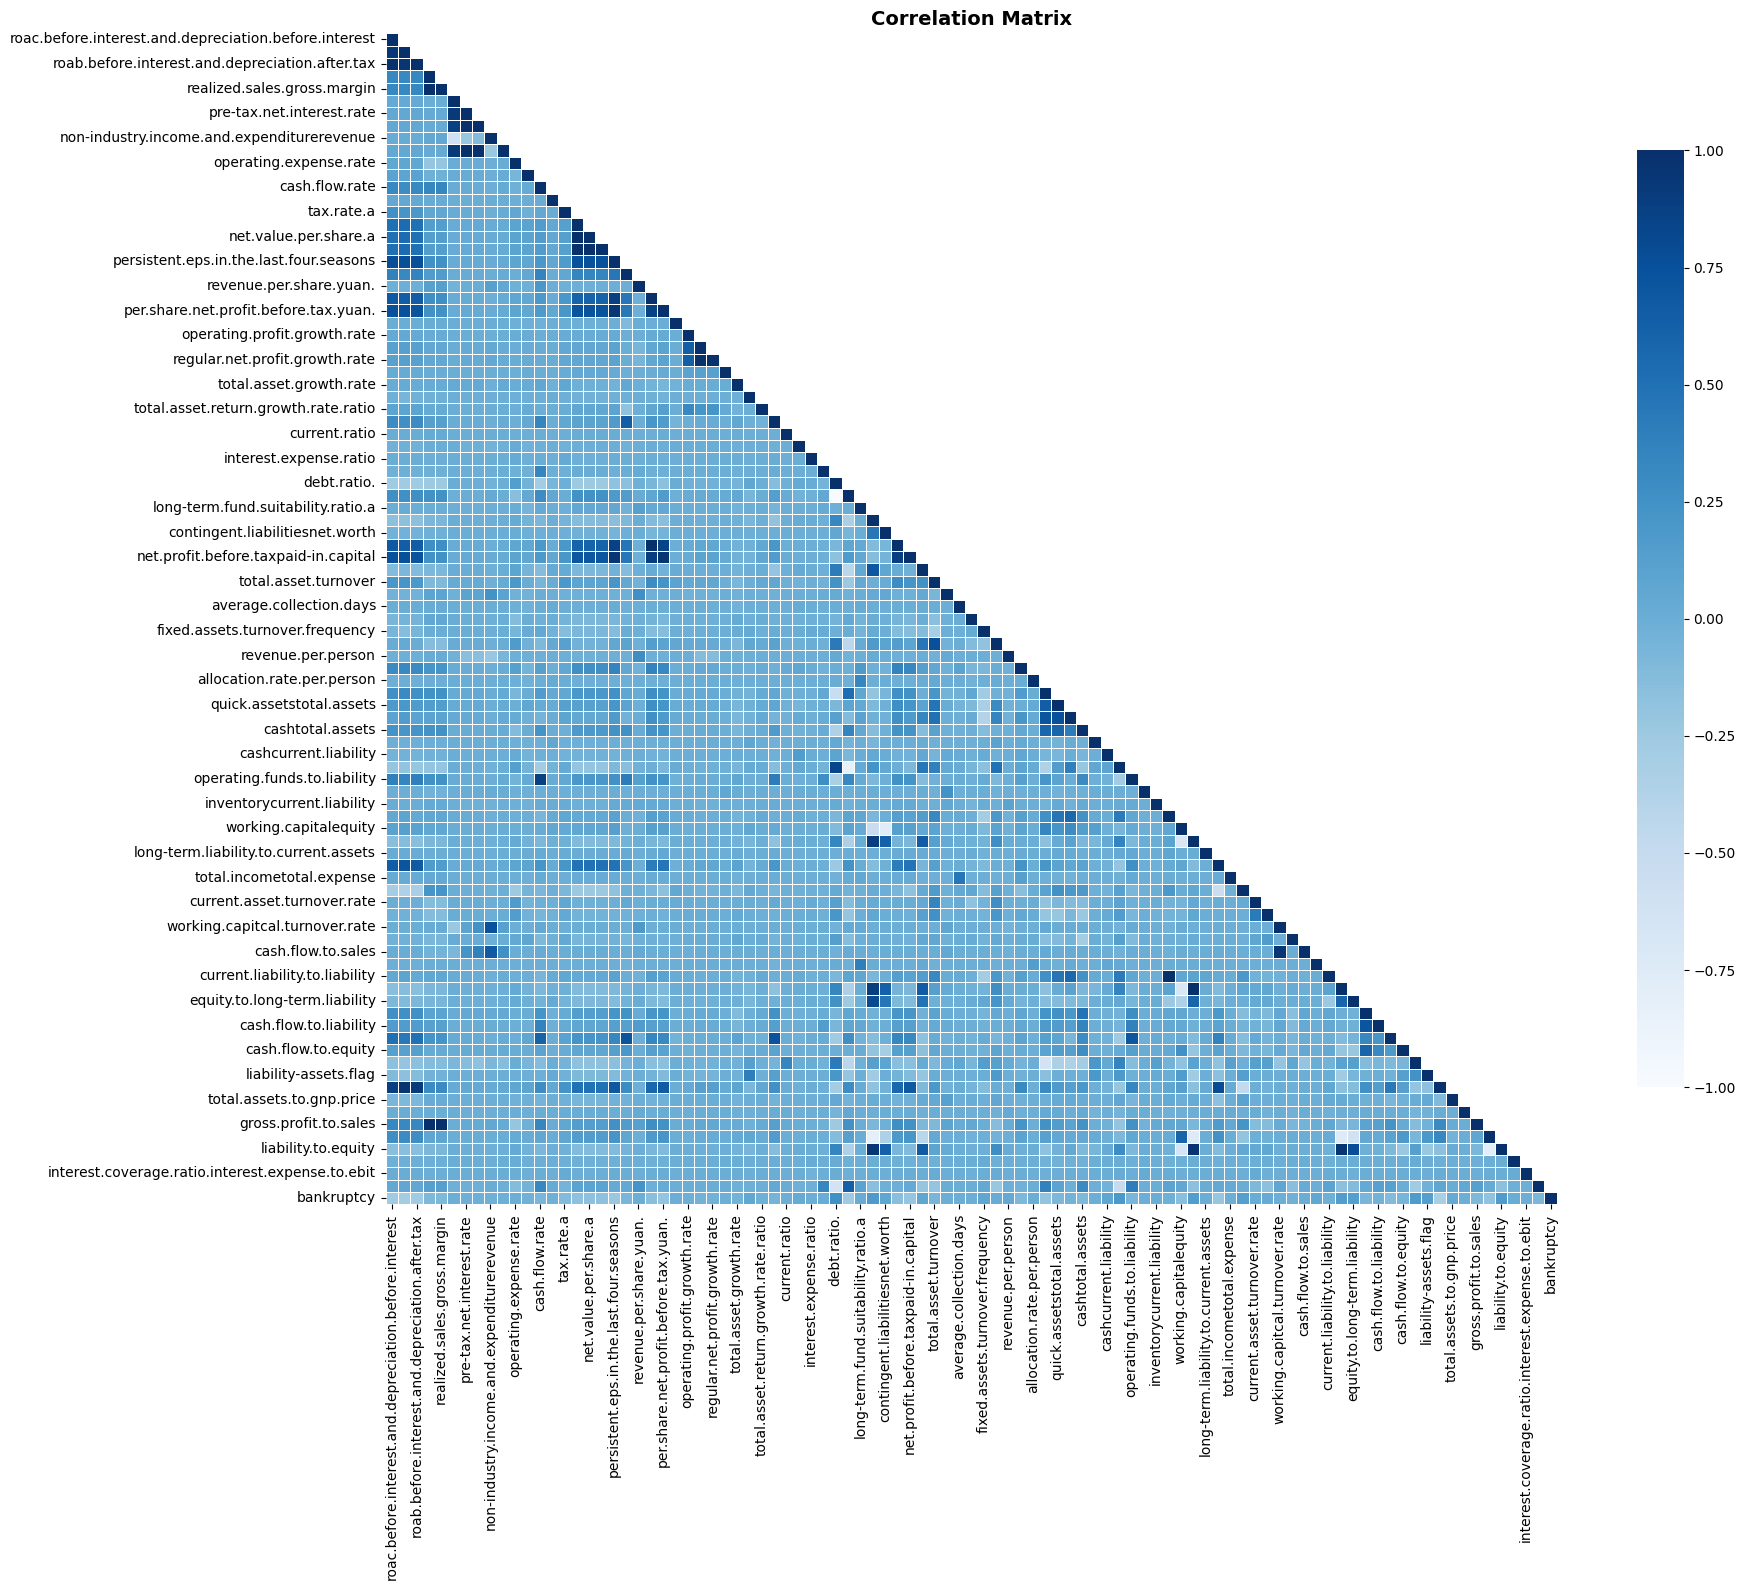

In [8]:
u.correlation_analysis(df_bankruptcy)

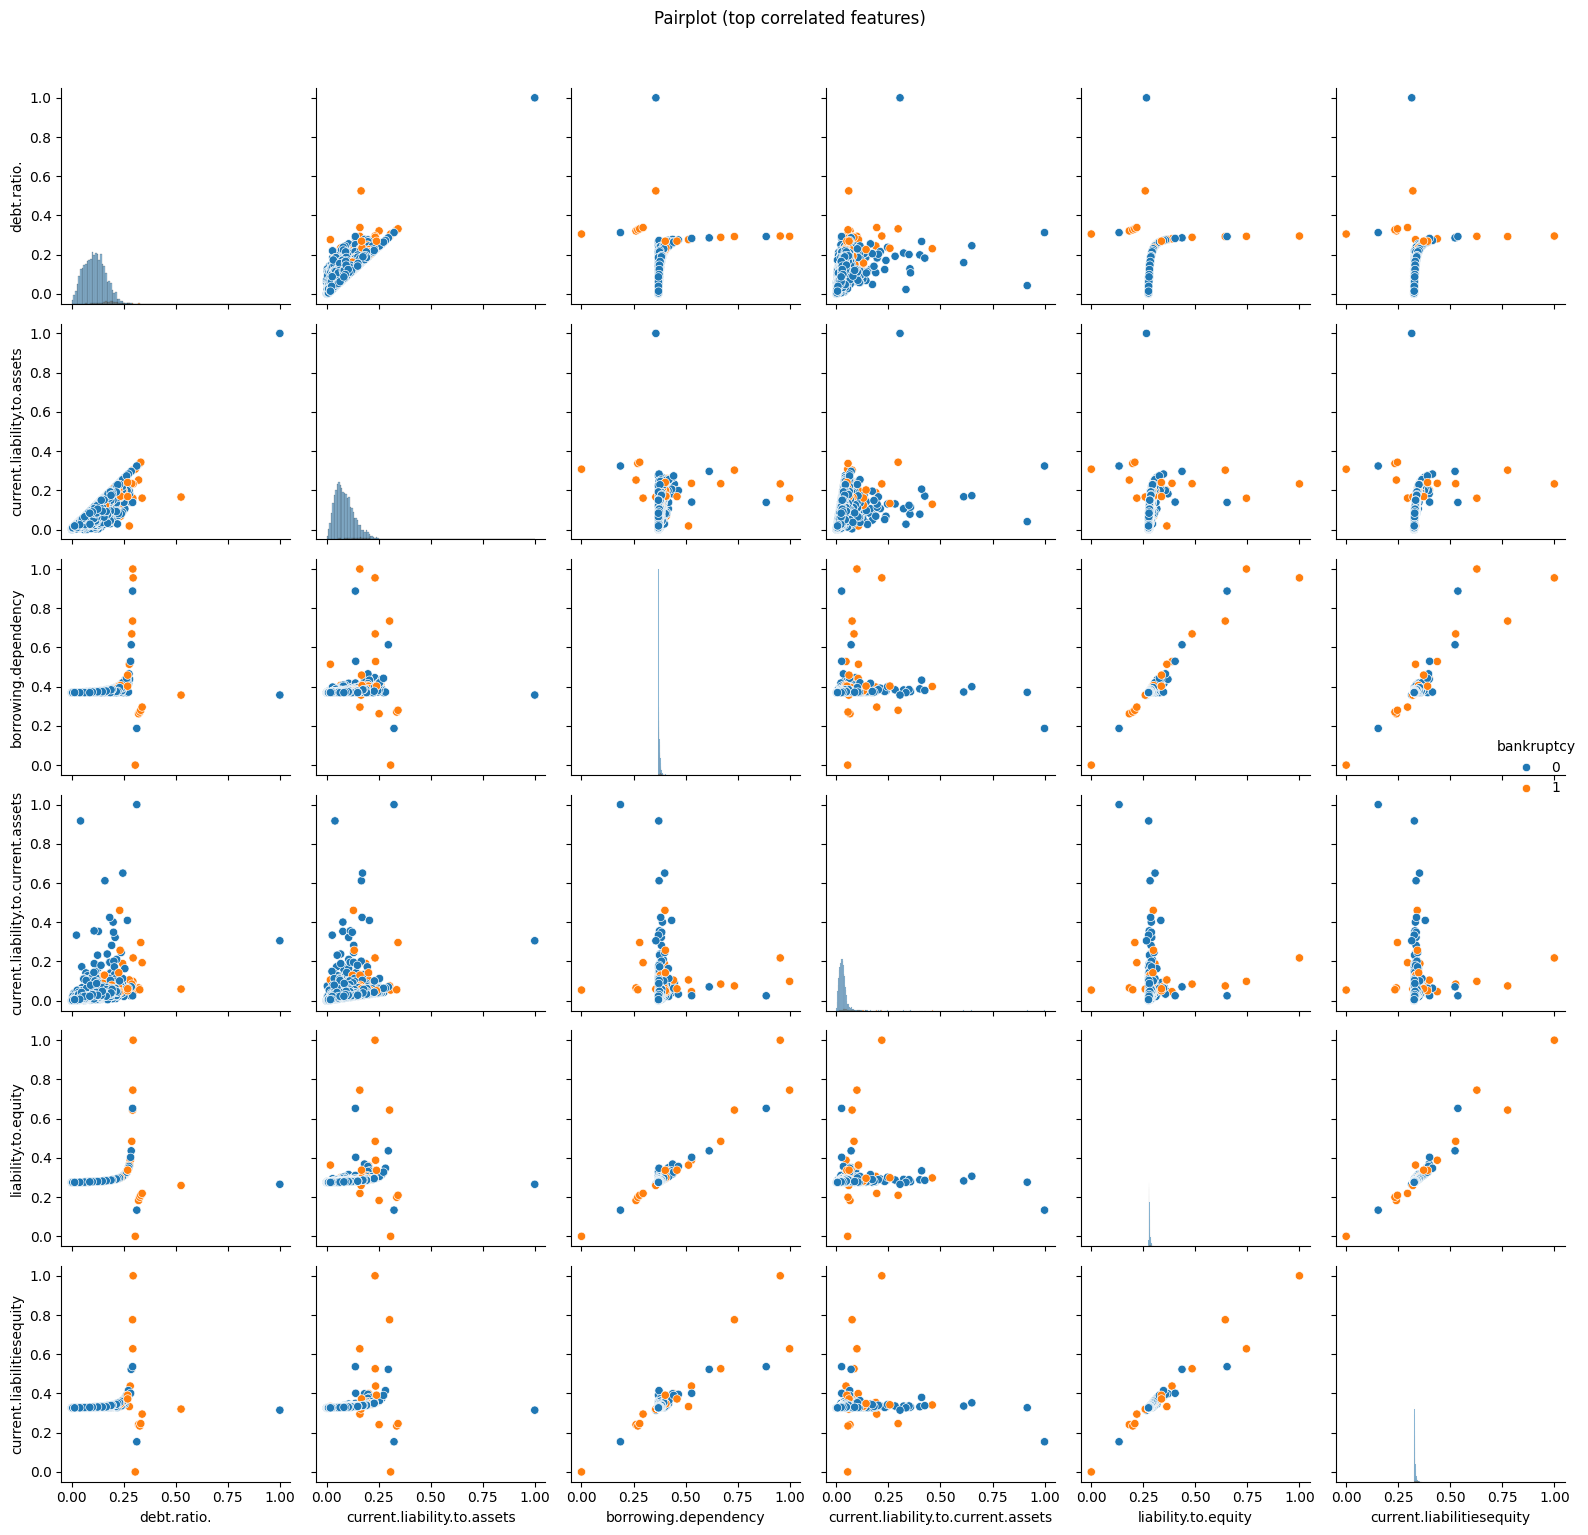

In [9]:
u.pairplots(df_bankruptcy, TARGET)


Correlation Analysis
--------------------------------------------------------------------------------

Top 6 POSITIVE correlations with 'bankruptcy':
 debt.ratio.                            0.250161
current.liability.to.assets            0.194494
borrowing.dependency                   0.176543
current.liability.to.current.assets    0.171306
liability.to.equity                    0.166812
current.liabilitiesequity              0.153828
Name: bankruptcy, dtype: float64

Top 6 NEGATIVE correlations with 'bankruptcy':
 persistent.eps.in.the.last.four.seasons                 -0.219560
net.worthassets                                         -0.250161
roac.before.interest.and.depreciation.before.interest   -0.260807
roab.before.interest.and.depreciation.after.tax         -0.273051
roaa.before.interest.and..after.tax                     -0.282941
net.income.to.total.assets                              -0.315457
Name: bankruptcy, dtype: float64


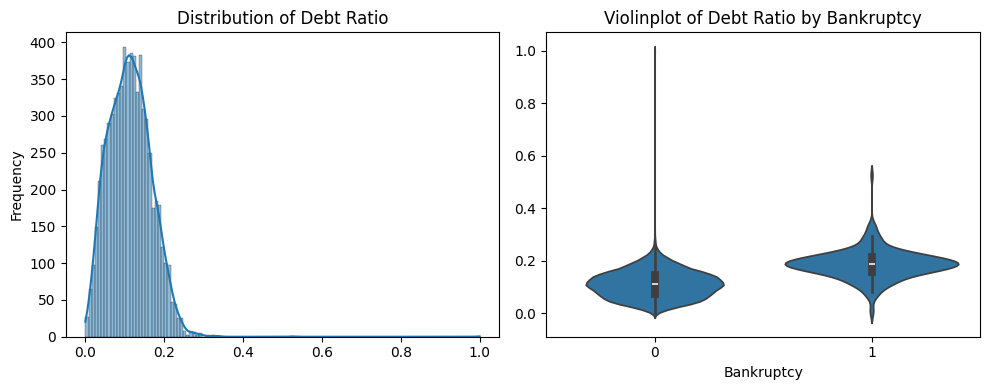

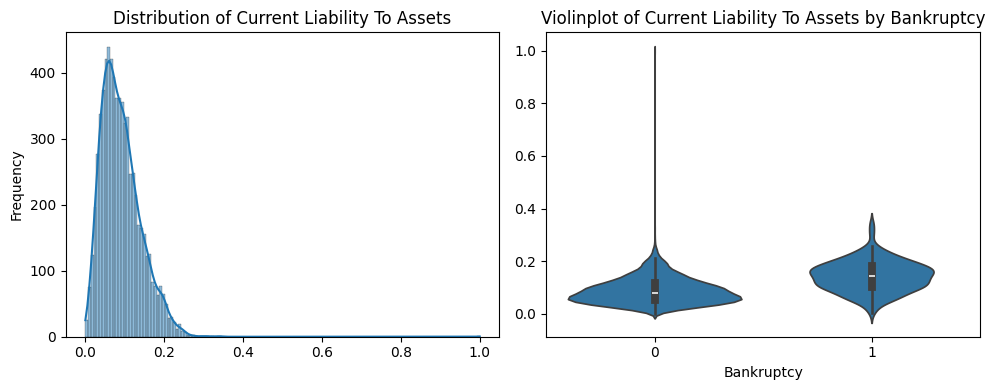

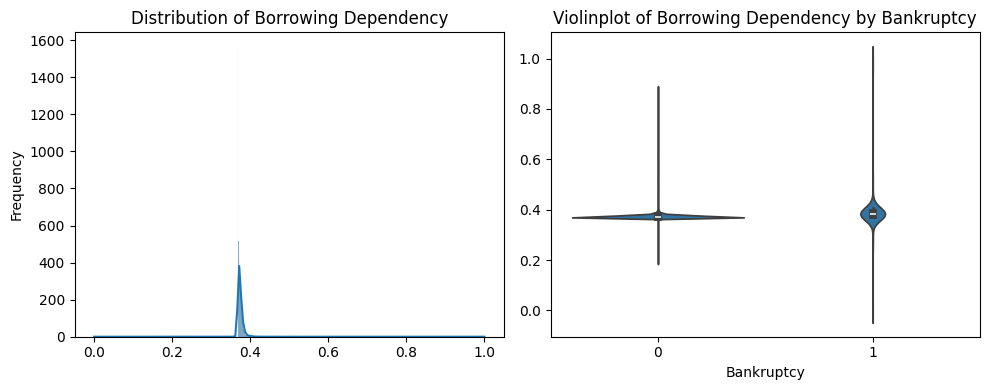

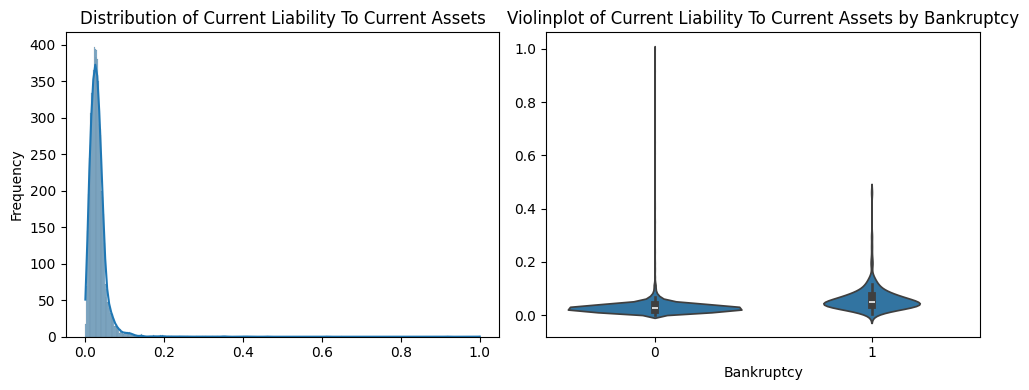

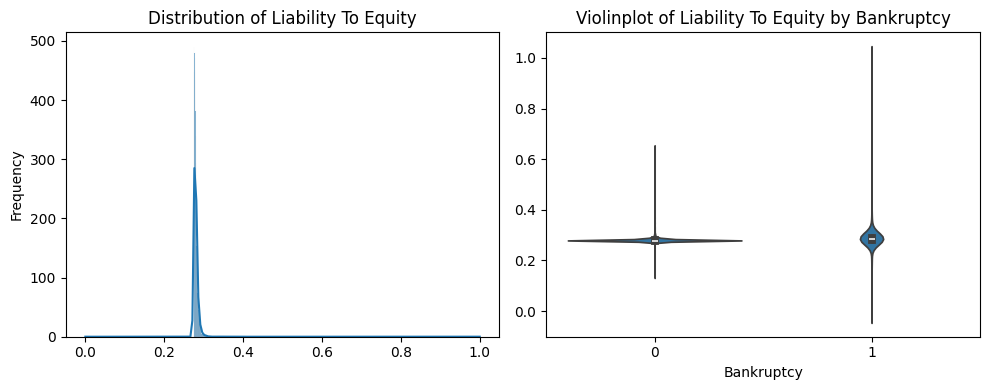

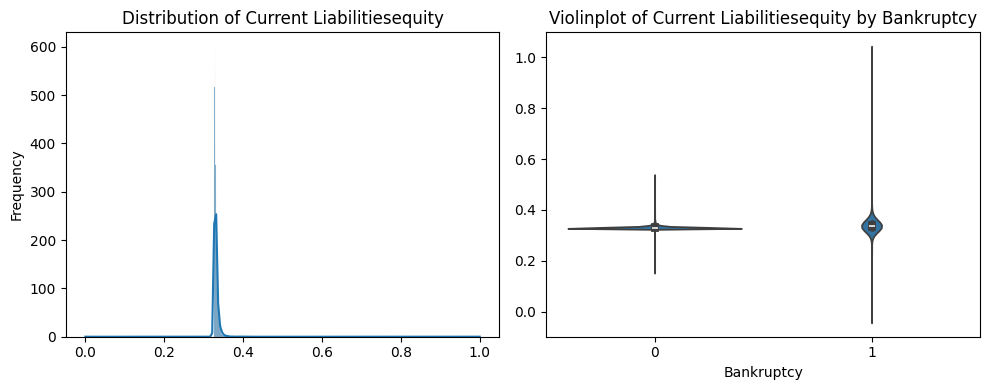

,bankruptcy
bankruptcy,1.000000
debt.ratio.,0.250161
current.liability.to.assets,0.194494
borrowing.dependency,0.176543
current.liability.to.current.assets,0.171306
liability.to.equity,0.166812
current.liabilitiesequity,0.153828
current.liability.to.equity,0.153828
liability-assets.flag,0.139212
total.expenseassets,0.139049


In [10]:
u.top_correlations(df_bankruptcy, TARGET, n=6)

Os gráficos com os 6 índices de maior correlação com a variável alvo sugerem que:

- **Debt Ratio** (Índice de Endividamento Total): Esse indice mostra quanto dos recursos da empresa está financiado por dívidas. No histograma, vemos que a maioria das empresas mantém valores baixos, entre 0,05 e 0,20. No entanto, ao observar o violinplot, percebemos que as empresas falidas apresentam uma mediana mais alta, ou seja, estavam mais alavancadas. Isso indica que o excesso de dívidas em relação ao total de recursos foi um fator associado à falência.

- **Current Liability to Assets** (Passivos de Curto Prazo sobre Ativos Totais): O índice compara quanto dos bens da empresa já está comprometido com dívidas que vencem em até 12 meses. A distribuição mostra que a maior parte das empresas tem valores próximos a zero, mas com uma cauda longa para valores mais altos. Entre as falidas, o violinplot mostra uma mediana superior, sugerindo que uma fatia maior dos ativos estavam comprometidos em dívidas imediatas, dificultando a liquidez.

- **Borrowing Dependency** (Dependência de Empréstimos):
Mede a dependência de financiamento externo. O histograma mostram concentração em torno de 0,38 e 0,40, indicando padrão semelhante entre a maioria das empresas. Porém, o violinplot revela que, nas falidas, há mais casos extremos, com dependência ainda maior de empréstimos. Isso sugere que, embora o comportamento médio seja parecido, os casos críticos estão mais presentes entre as falidas.

- **Current Liability to Current Assets** (Passivos de Curto Prazo sobre Ativos de Curto Prazo): Esse índice avalia se os recursos de curto prazo (como caixa e estoques) são suficientes para cobrir dívidas também de curto prazo. Os gráficos mostram que, para a maioria, os valores são baixos, próximos de 0,05. Contudo, o violinplot mostra que, nas falidas, a distribuição é mais espalhada e com valores maiores, evidenciando empresas cujo caixa não suportava o volume de dívidas imediatas.

- **Liability to Equity** (Dívidas sobre Patrimônio Próprio)
O índice indica o equilíbrio entre o capital próprio e as dívidas. A maior parte das empresas se concentra em torno de 0,25 e 0,30. O violinplot mostra que as falidas têm mediana mais alta e uma cauda longa, sugerindo que elas recorriam mais a dívidas do que a recursos próprios, aumentando sua vulnerabilidade.

- **Current Liabilities to Equity** (Passivos de Curto Prazo sobre Patrimônio Próprio): Esse índice foca especificamente nas dívidas que vencem em até 12 meses em comparação ao patrimônio. Os gráficos mostram pouca dispersão, mas novamente as falidas exibem valores medianos mais elevados e maior variação. Isso reforça que, nessas empresas, o peso das dívidas de curto prazo sobre o patrimônio era mais expressivo.

### Distribuição da Variavel Alvo

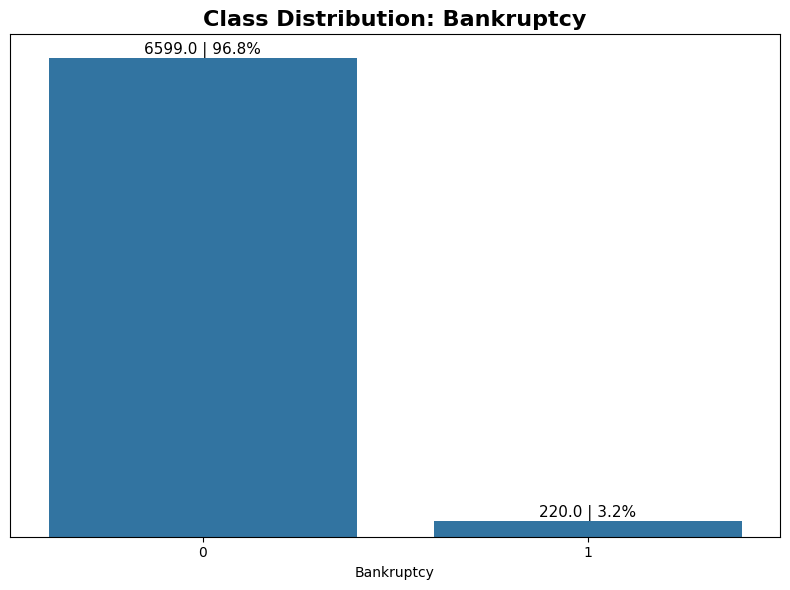

In [11]:
u.class_imbalance(df_bankruptcy, TARGET)

O gráfico apresenta a distribuição das classes da variável alvo Bankruptcy, evidenciando um forte desbalanceamento nos dados. Do total de observações, 599 empresas (96,8%) pertencem à classe de empresas que não faliram (0), enquanto apenas 220 empresas (3,2%) correspondem ao grupo de empresas que faliram. Essa diferença significativa mostra que os casos de falência são minoritários no conjunto de dados, o que pode impactar diretamente o desempenho de modelos preditivos, exigindo estratégias específicas de balanceamento (como oversampling, undersampling ou algoritmos sensíveis a desbalanceamento) para evitar que o modelo aprenda a simplesmente prever a classe majoritária.

## Separação dos conjunto de dados

A função `splitdata` separa os dados em: treinamento, validação e teste, garantindo que a proporção de classes seja mantida.

Considerando que o conjunto de dados é altamente desbalanceado, ao utilizaro o parametro `use_stratify=True` garantimos que a proporção das classes seja mantida, para que cada conjunto tenha representatividade das duas classes.

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = u.splitdata(df_bankruptcy, SEED, TARGET)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape X_val: {X_val.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape y_val: {y_val.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (5455, 95)
Shape X_val: (1091, 95)
Shape X_test: (273, 95)
Shape y_train: (5455,)
Shape y_val: (1091,)
Shape y_test: (273,)


## Normalização e Engenharia de Atributos

Como observado na analise exploratória, o conjunto de dados possui indices financeiros com distribuições anormais ou escalas muito diferentes, dessa forma, para melhorar a performance do modelo aplicamos algumas transformações:

- Primeiro, através da função `check_signal` checamos o sinal dos valores presentes em cada indice financeiro.

In [13]:
positive, positive_and_negative, negative = u.check_signal(df_bankruptcy, exclude=TARGET).values()
print(f'Positive: {positive}\n')
print(f'Both: {positive_and_negative}\n')
print(f'Negative: {negative}\n')

Positive: ['roac.before.interest.and.depreciation.before.interest', 'roaa.before.interest.and..after.tax', 'roab.before.interest.and.depreciation.after.tax', 'operating.gross.margin', 'realized.sales.gross.margin', 'operating.profit.rate', 'pre-tax.net.interest.rate', 'after-tax.net.interest.rate', 'non-industry.income.and.expenditurerevenue', 'continuous.interest.rate.after.tax', 'operating.expense.rate', 'research.and.development.expense.rate', 'cash.flow.rate', 'interest-bearing.debt.interest.rate', 'tax.rate.a', 'net.value.per.share.b', 'net.value.per.share.a', 'net.value.per.share.c', 'persistent.eps.in.the.last.four.seasons', 'cash.flow.per.share', 'revenue.per.share.yuan.', 'operating.profit.per.share.yuan.', 'per.share.net.profit.before.tax.yuan.', 'realized.sales.gross.profit.growth.rate', 'operating.profit.growth.rate', 'after-tax.net.profit.growth.rate', 'regular.net.profit.growth.rate', 'continuous.net.profit.growth.rate', 'total.asset.growth.rate', 'net.value.growth.rate',

Todas as colunas preditoras têm valores mínimos ≥ 0, o que significa que podemos aplicar transformação logarítmica diretamente sem lidar com valores negativos.

Após a identificação do sinal, identificamos a assimetria do indice afim de detectar os indices com assimetria à direita.

In [14]:
right_skewed = u.find_right_skewed(df_bankruptcy, positive, skew_threshold=3.0, target='bankruptcy')

print('Columns: ', len(right_skewed),'\n')
right_skewed

Columns:  49 



['non-industry.income.and.expenditurerevenue',
 'cash.flow.rate',
 'interest-bearing.debt.interest.rate',
 'net.value.per.share.b',
 'net.value.per.share.a',
 'net.value.per.share.c',
 'persistent.eps.in.the.last.four.seasons',
 'cash.flow.per.share',
 'revenue.per.share.yuan.',
 'operating.profit.per.share.yuan.',
 'per.share.net.profit.before.tax.yuan.',
 'realized.sales.gross.profit.growth.rate',
 'continuous.net.profit.growth.rate',
 'net.value.growth.rate',
 'total.asset.return.growth.rate.ratio',
 'current.ratio',
 'quick.ratio',
 'total.debttotal.net.worth',
 'long-term.fund.suitability.ratio.a',
 'borrowing.dependency',
 'contingent.liabilitiesnet.worth',
 'operating.profitpaid-in.capital',
 'net.profit.before.taxpaid-in.capital',
 'inventory.and.accounts.receivablenet.value',
 'accounts.receivable.turnover',
 'average.collection.days',
 'net.worth.turnover.rate.times',
 'revenue.per.person',
 'operating.profit.per.person',
 'allocation.rate.per.person',
 'quick.assetscurrent.l

Foi identificada 49 colunas com assimetria maios que 3.0, o que indica que uma transformação logarítmica pode ajudar a normalizar os valores.

A função `log1p_transform` aplica a função logaritima nas colunas com alta assimetria a direita, reduzindo a influência de valores.

Todas as funções de transformações foram atreladas a um pipeline, com as seguintes etapas:
- log1p: Aplica log1p_transform às colunas enviesadas identificadas.
- VarianceThreshold: Remove variaveis que são constantes após o log
- MinMaxScaler: Normaliza todas as colunas para a faixa [0, 1], preservando a forma das distribuições.

In [15]:
pipe = ImbPipeline(steps=[
    ('log1p', FunctionTransformer(u.log1p_transform, kw_args={'cols': right_skewed})),
    ('var', VarianceThreshold(threshold=0.0)),
    ('scaler', MinMaxScaler()),
])

A aplicação do `fit_transform` no conjunto de treino e `transform` nos conjuntos de validação e teste, assim as transformações do pipeline são aprendidas no conjunto de treino e aplicadas no conjunto de teste e validação, garantindo consistência no pré-processamento.

O resultado são `X_train_ready`, `X_val_ready` e `X_test_ready`, que contêm os indices prontos para alimentar os modelos.

In [16]:
X_train_ready = pipe.fit_transform(X_train)
X_val_ready  = pipe.transform(X_val)
X_test_ready = pipe.transform(X_test)

In [17]:
X_train_ready.shape

(5455, 94)

As linhas de código abaixo foi aplicada apenas para visualização e confirmação de que a transformação log foi aplicada corretamente as colunas selecionadas.

In [18]:
log_only = FunctionTransformer(u.log1p_transform, kw_args={'cols': right_skewed})
X_train_log = log_only.fit_transform(X_train)

for c in right_skewed[:5]:
    rec = np.expm1(X_train_log[c].values)
    diff = np.max(np.abs(rec - X_train[c].clip(lower=0).values))
    print(f'{c}: max|expm1(log1p)-orig| = {diff:.3e}')

before = X_train[right_skewed].skew(numeric_only=True)
after  = X_train_log[right_skewed].skew(numeric_only=True)
skew_df = pd.DataFrame({'before': before, 'after': after, 'var': after - before}).sort_values('var')
print(skew_df.head(10))

non-industry.income.and.expenditurerevenue: max|expm1(log1p)-orig| = 5.551e-17
cash.flow.rate: max|expm1(log1p)-orig| = 1.110e-16
interest-bearing.debt.interest.rate: max|expm1(log1p)-orig| = 1.431e-06
net.value.per.share.b: max|expm1(log1p)-orig| = 5.551e-17
net.value.per.share.a: max|expm1(log1p)-orig| = 5.551e-17
                                               before      after        var
fixed.assets.to.assets                      73.857972  53.080964 -20.777008
total.debttotal.net.worth                   49.737412  30.160700 -19.576712
net.value.growth.rate                       71.813707  52.322158 -19.491549
total.asset.return.growth.rate.ratio        56.108180  42.525423 -13.582756
average.collection.days                     35.362384  23.460569 -11.901815
non-industry.income.and.expenditurerevenue  41.065726  29.711282 -11.354445
continuous.net.profit.growth.rate           60.072396  49.033915 -11.038481
current.liabilitiesequity                   24.269191  13.545578 -10.72361

## Modelagem com LogisticRegression

Antes da aplicação de modelos de redes neurais, testamos um modelo simples de Regressão Logística como baseline.

Para lidar com o desbalanceamento, usamos `class_weight='balanced'`, o que ajusta automaticamente os pesos inversamente às frequências das classes, assim, erros em amostras da classe minoritária (falência) recebem maior penalidade durante o treinamento.

In [19]:
lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=SEED, n_jobs=-1)
lr.fit(X_train_ready, y_train)

val_pred  = lr.predict(X_val_ready)
val_proba = lr.predict_proba(X_val_ready)[:, 1]

print('Classification Report | Baseline:')
print(classification_report(y_val, val_pred, digits=4))
print('F1      :', round(f1_score(y_val, val_pred), 4))
print('AUC-ROC :', round(roc_auc_score(y_val, val_proba), 4))

Classification Report | Baseline:
              precision    recall  f1-score   support

           0     0.9977    0.8267    0.9042      1056
           1     0.1528    0.9429    0.2629        35

    accuracy                         0.8304      1091
   macro avg     0.5752    0.8848    0.5836      1091
weighted avg     0.9706    0.8304    0.8836      1091

F1      : 0.2629
AUC-ROC : 0.9496


Para a classe de falência, a precisão ficou em ~15,3%, enquanto o recall foi de ~94,3%. Indicando que o modelo identificoua maioria das empresas que de fato faliam, mas gerou muitos falsos positivos.

O modelo mostrou uma AUC-ROC de 0,95, o que significa que ele é bom em separar empresas de maior e menor risco de falência.

## Modelagem com TF.KERAS

Usamos uma rede neural, com Keras, para tentar capturar a não-linearidades. A arquitetura escolhida combina camadas densas e dropout para evitar overfitting.

In [20]:
# Definição da arquitetura
def build_mlp(input_dim: int) -> tf.keras.Model:      # Define a camada de entrada
  model = Sequential([                                # Cria um modelo sequencial, onde as camadas são adicionadas em ordem
      layers.Input((input_dim,)),                     # Camada de entrada com número de atributos

      # 1ª Camada
      layers.Dense(128, use_bias=False),              # Camada oculta, com 128 neurônios, sem bias
      layers.BatchNormalization(),                    # Normaliza as ativações para deixar o treinamento mais estável
      layers.ReLU(),                                  # Função de ativação que “liga/desliga” neurônios de forma não linear
      layers.Dropout(0.20, seed=SEED),                           # Desliga aleatoriamente 20% dos neurônios nessa camada a cada iteração

      # 2ª Camada
      layers.Dense(64, use_bias=True),                # Camada oculta, com 64 neurônios, com bias incluido
      layers.BatchNormalization(),                    # Normaliza as ativações para deixar o treinamento mais estável
      layers.ReLU(),                                  # Função de ativação que “liga/desliga” neurônios de forma não linear
      layers.Dropout(0.10, seed=SEED),                           # Desliga aleatoriamente 10% dos neurônios nessa camada a cada iteração

      # 3ª Camada
      #layers.Dense(32, activation='relu'),
      #layers.Dropout(0.05),

      layers.Dense(1, activation='sigmoid')          # Transforma o valor de saída em uma probabilidade entre 0 e 1.
    ])

  return model

In [21]:
# Instancia o modelo definindo a dimensão de entrada

model = build_mlp(input_dim=X_train_ready.shape[1])

In [22]:
# Compilação do modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),   # Definição do otimizador Adam
    loss='binary_crossentropy',                               # Definição da perda para classificação binária
    metrics=[                                                 # Definição das métricas
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,121 (82.50 KB)

 Trainable params: 20,737 (81.00 KB)

 Non-trainable params: 384 (1.50 KB)

O método `.summary()` exibe as camadas e número de parâmetros. No final, temos cerca de 21.121 parâmetros no modelo.

In [24]:
# Definição das regras de treinamento

# EarlyStopping: interrompe o treinamento se 'val_auc' não melhorar por várias épocas, restaurando os melhores pesos vistos
early = callbacks.EarlyStopping(
    monitor='val_auc',          # acompanha a AUC na validação a cada época.
    patience=10,                # se passar 10 épocas seguidas sem melhora, ele interrompe o treinamento.
    restore_best_weights=True   # o modelo volta para os melhores pesos já encontrados
)

# Reduz a taxa de aprendizado se 'val_auc' parar de melhorar por alguns passos.
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',        # acompanha as métricas de validação
    factor=0.5,               # quando ativa, corta a taxa de aprendizado pela metade.
    patience=3,               # espera 3 épocas sem melhora antes de reduzir a taxa
    min_lr=1e-6,              # valor mínimo que a taxa de aprendizado pode ter
    verbose=1                 # imprime mensagens para avisar quando a taxa de aprendizado foi ajustada
)

Em suma, com a definição das regras de treinamento, se o modelo parar de aprender, ele “diminui a velocidade” da atualização dos pesos, para tentar sair de um platô e continuar melhorando.

Considerando que o conjunto de dados está altamente desbalanceado, portando possui mais empresas que não faliram [0] do que empresas que faliram [1]). Assim para ajudar o modelo calcula-se um peso maior para a classe minoritária.

Primeiro divide a quantidade de não-falidas pelo número de falidas para obter um peso bruto, de modo a dar mais importância às falidas durante o treino. Também é definido um limite para que o peso não fique exagerado e atrapalhe o treinamento.

In [25]:
# Calcula pesos de classes manualmente para a classe falida:
counts = Counter(y_train)
w_pos_raw = counts[0] / counts[1]
w_pos = min(w_pos_raw, 17.0)
class_weight = {0: 1.0, 1: w_pos}

Treinamos o modelo fornecendo o conjunto de validação para a verificação do desempenho

In [26]:
# Treinamento
history = model.fit(
    X_train_ready, y_train,                 # Dados de treino
    validation_data=(X_val_ready, y_val),   # Dados de validação, para monitorar o desempenho
    epochs=100,                             # até 100 rodadas de treinamento.
                                            # Obs.: Apesar de ser definido 100 rodadade de treinamento,
                                            # o modelo poderá parar antes devido as configurações do
                                            # EarlyStopping

    callbacks=[early, reduce_lr],           # Define as regras automáticas:
                                            # EarlyStopping para parar se não melhorar, e
                                            # ReduceLr para ajustar a taxa de aprendizado

    batch_size=32,                          # Modelo aprende em “lotes” de 32 exemplos por vez
    class_weight=class_weight,              # Aplica os pesos calculados corrigir o desbalanceamento
    verbose=1                               # Exibe o progresso do treinamento
)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5311 - auc: 0.7013 - loss: 0.9801 - precision: 0.0552 - recall: 0.7991 - val_accuracy: 0.9688 - val_auc: 0.8515 - val_loss: 0.2186 - val_precision: 1.0000 - val_recall: 0.0286 - learning_rate: 0.0010
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8795 - auc: 0.8941 - loss: 0.5524 - precision: 0.1723 - recall: 0.7668 - val_accuracy: 0.9578 - val_auc: 0.9063 - val_loss: 0.1760 - val_precision: 0.2963 - val_recall: 0.2286 - learning_rate: 0.0010
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8936 - auc: 0.9104 - loss: 0.5026 - precision: 0.1878 - recall: 0.7440 - val_accuracy: 0.9212 - val_auc: 0.9299 - val_loss: 0.2027 - val_precision: 0.2524 - val_recall: 0.7429 - learning_rate: 0.0010
Epoch 4/100
155/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9006 - auc: 0.9184 - loss: 0.4595 - precision: 0.1993 - recall: 0.7428
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000500

## Métricas de Validação

Na variavel `val_proba` é construido um vetor com as probabilidades de falência previstas pelo modelo para cada empresa no conjunto de validação.

In [27]:
# Probabilidades de validação
val_proba = model.predict(X_val_ready, verbose=0).ravel()
val_proba

array([0.02154427, 0.01288554, 0.00619749, ..., 0.00671109, 0.08083263,
       0.02082692], dtype=float32)

Buscamos o ponto de corte ideal para transformar as probabilidades do modelo em previsões binárias. Ele calcula precisão e recall em vários limiares possíveis, combina esses valores para obter o F1-score em cada ponto e identifica onde o equilíbrio entre precisão e recall é máximo. O resultado é o melhor threshold, ou seja, o valor de probabilidade a partir do qual o modelo passa a considerar uma empresa como falida, maximizando a qualidade das previsões.

In [28]:
# Calculo do ponto de equilíbrio entre precisão e recall.
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1 = 2*prec*rec/(prec+rec+1e-12)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx-1] if best_idx > 0 else 0.5
print(f'Best F1(val) = {f1[best_idx]:.4f} at threshold = {best_thr:.4f}')

Best F1(val) = 0.4404 at threshold = 0.7918


Dessa forma se a probabilidade prevista pelo modelo for maior que 0.8485, a empresa é classificada como falida (classe 1). Se for menor ou igual a 0.8485, ela é classificada como não falida (classe 0).

In [29]:
val_pred_best = (val_proba >= best_thr).astype(int)

### Relatório de Classificação

In [30]:
print('\nClassification report | tf.keras (VAL, thr*=val):')
print(classification_report(y_val, val_pred_best, digits=4))
print('F1      :', round(f1_score(y_val, val_pred_best), 4))
print('AUC-ROC :', round(roc_auc_score(y_val, val_proba), 4))


Classification report | tf.keras (VAL, thr*=val):
              precision    recall  f1-score   support

           0     0.9892    0.9517    0.9701      1056
           1     0.3200    0.6857    0.4364        35

    accuracy                         0.9432      1091
   macro avg     0.6546    0.8187    0.7032      1091
weighted avg     0.9677    0.9432    0.9530      1091

F1      : 0.4364
AUC-ROC : 0.9327


Com o threshold ajustado para aproximadamente 0.8485, o modelo apresentou desempenho equilibrado entre as classes. Para empresas não falidas (classe 0), o modelo alcançou precisão de 0,9911 e recall de 0,9508, resultando em um f1-score de 0,9705, mostrando que raramente erra ao identificar casos saudáveis.

Já para empresas falidas (classe 1), a precisão foi de 0,3333 e o recall de 0,7429, com f1-score de 0,4602. Isso significa que o modelo conseguiu recuperar cerca de dois terços das falências reais, ainda que com alguns falsos alarmes. A acurácia global foi de 0,9441, e a AUC-ROC atingiu 0,9419, confirmando a boa capacidade discriminativa.

Comparando com o baseline, observa-se que a rede neural privilegia o recall da classe falida, chegando a 0,9508, mas com precisão muito baixa, o que derruba seu f1-score para 0,4602. Assim, embora o baseline detecte quase todas as falências, ele gera muitos falsos positivos, enquanto a rede neural com o threshold ajustado entrega resultados mais equilibrados e melhora substancialmente a confiabilidade da classificação.

### Curva de Validação

In [31]:
# Curvas de Validação
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

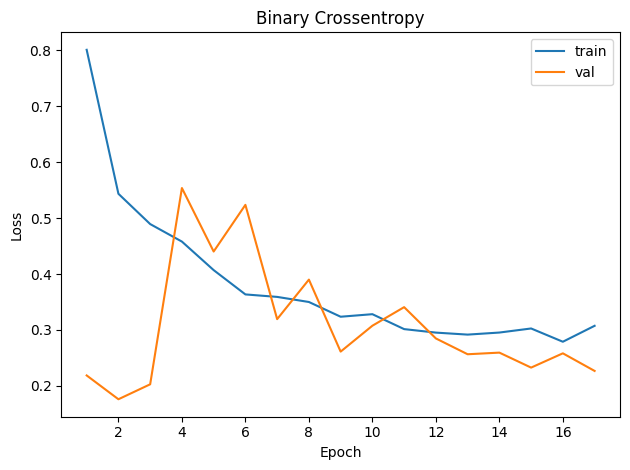

In [32]:
# Curva de perda
plt.figure()
plt.plot(epochs, hist['loss'], label='train')
plt.plot(epochs, hist['val_loss'], label='val')
plt.title('Binary Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

A curva de perda sugere que o modelo está aprendendo de forma consistente. A perda de validação estabilizada em valores menores que a de treino indica boa generalização e que a rede está conseguindo capturar padrões relevantes sem decorar os dados de treino.

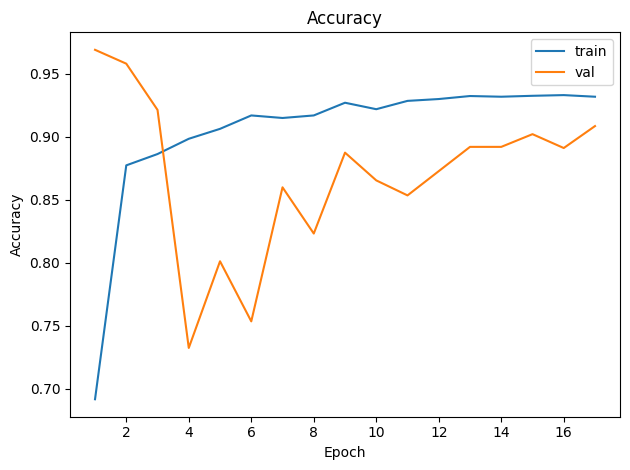

In [33]:
# Curva de acurácia
if 'accuracy' in hist and 'val_accuracy' in hist:
    plt.figure()
    plt.plot(epochs, hist['accuracy'], label='train')
    plt.plot(epochs, hist['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

O gráfico mostra a evolução da acurácia ao longo das épocas de treinamento para os conjuntos de treino e validação, observa-se que a acurácia de treino cresce rapidamente nas primeiras épocas, estabilizando-se em torno de 0,91. Já a acurácia de validação começa muito alta nas primeiras iterações, apresenta oscilações significativas até cerca da época 10 e depois se estabiliza. Essa diferença entre treino e validação sugere que o modelo se desenvolve bem, mas com pequenas perdas de desempenho em dados não vistos.

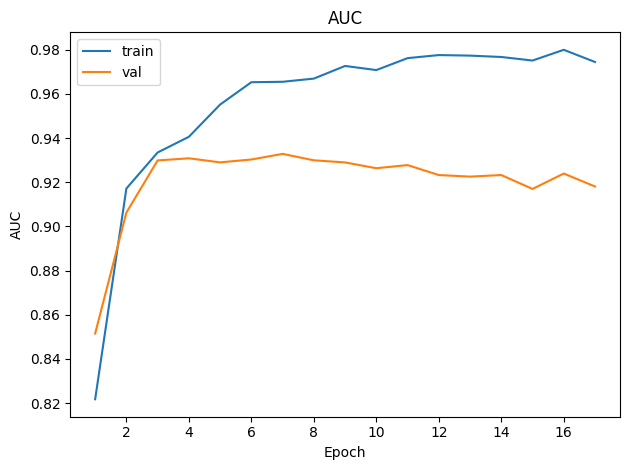

In [34]:
# Curva de AUC
if 'auc' in hist and 'val_auc' in hist:
    plt.figure()
    plt.plot(epochs, hist['auc'], label='train')
    plt.plot(epochs, hist['val_auc'], label='val')
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()

O gráfico apresenta a evolução da métrica AUC (Área sob a Curva ROC) durante o treinamento, tanto para o conjunto de treino quanto para o de validação. Observa-se que, já nas primeiras épocas, a AUC de validação atinge valores elevados próximos de 0,94, mantendo-se estável ao longo do processo, enquanto a AUC de treino cresce progressivamente até estabilizar em torno de 0,97. Esses valores indicam que o modelo tem excelente capacidade de discriminação entre empresas falidas e não falidas, com performance consistente nos dados de validação e sem sinais de sobreajuste, uma vez que ambas as curvas se mantêm próximas e em patamares altos.

## Avaliação Final em Teste

A avaliação final de desempenho do modelo será feita no conjunto de teste. Primeiro, será calculada a perda e as métricas definidas no treinamento por meio do método evaluate, garantindo que a análise seja feita em dados nunca vistos.

Em seguida, recupera os nomes das métricas associadas ao modelo e percorre os resultados, exibindo cada métrica com seu respectivo valor formatado. Dessa forma, o código fornece uma visão clara e resumida da performance do modelo em termos de erro e qualidade de classificação, funcionando como a etapa final de validação da sua capacidade de generalização.

In [35]:
# Avaliação no conjunto de teste com saída em dicionário
test_results = model.evaluate(X_test_ready, y_test, return_dict=True, verbose=0)

print('Test metrics | tf.keras:\n')
for name, value in test_results.items():
    print(f'{name}: {value:.4f}')

Test metrics | tf.keras:

accuracy: 0.8864
auc: 0.9310
loss: 0.2560
precision: 0.1765
recall: 0.6667


In [36]:
y_proba = model.predict(X_test_ready, verbose=0).ravel()
y_pred  = (y_proba >= best_thr).astype(int)

print('Classification report | tf.keras (TEST, thr*=val):')
print(classification_report(y_test, y_pred, digits=4))
print('F1      :', round(f1_score(y_test, y_pred),4))
print('AUC-ROC :', round(roc_auc_score(y_test, y_proba),4))

Classification report | tf.keras (TEST, thr*=val):
              precision    recall  f1-score   support

           0     0.9883    0.9621    0.9750       264
           1     0.3750    0.6667    0.4800         9

    accuracy                         0.9524       273
   macro avg     0.6817    0.8144    0.7275       273
weighted avg     0.9681    0.9524    0.9587       273

F1      : 0.48
AUC-ROC : 0.9306


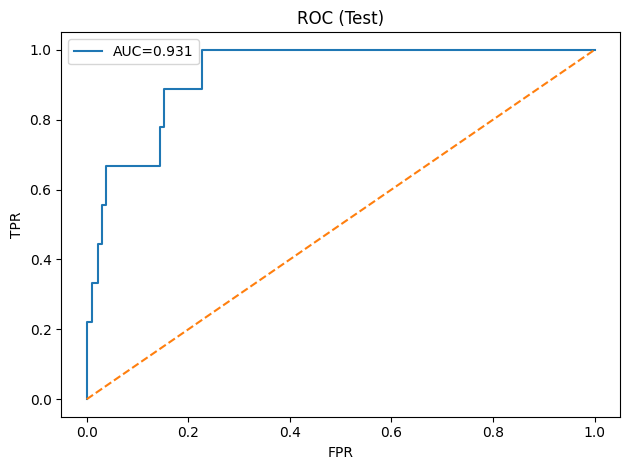

In [37]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Test)'); plt.legend()
plt.tight_layout(); plt.show()

Os resultados obtidos no conjunto de teste mostram que o modelo apresenta bom poder discriminativo, com AUC de 0,90, indicando alta capacidade de diferenciar empresas falidas das não falidas. A acurácia global de 0,95 reforça essa consistência, embora haja um desbalanceamento entre as métricas por classe: para empresas não falidas (classe majoritária), a precisão e o recall são muito altos (0,99 e 0,96, respectivamente), enquanto para empresas falidas (classe minoritária) a precisão é mais baixa (0,40) e o recall moderado (0,67). Isso significa que o modelo consegue capturar uma parte relevante dos casos de falência, mas ainda gera falsos positivos. De forma geral, o desempenho confirma que a rede neural aprendeu padrões importantes para identificar risco de insolvência, mas evidencia também os desafios inerentes ao desbalanceamento de classes.